# Assingment 2: Explainable AI and Hyperparameter Optimization

Samih Amer

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 72
import numpy as np
import pandas as pd, re
import re
from collections import defaultdict
from numpy.linalg import norm
from scipy.spatial.distance import cosine 
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import gzip, io
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score

In [2]:
df_movies = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_movie.csv')
df_ratings = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_rating.csv')

tags = pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_genome_tags.csv')
scores =  pd.read_csv(r'/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/movielens/movielens_genome_scores.csv')

genres_df = df_movies[['movieId', 'genres']].copy()

## Problem 1 - Rework the movielens dataset to determine a set of 19 tags that explains one of the 19 Genres while having an inert relation with the rest of the genres

In [3]:
GENRES = ['Action','Adventure','Animation',"Children",'Comedy','Crime',
          'Documentary','Drama','Fantasy','Film-Noir','Horror','Musical',
          'Mystery','Romance','Sci-Fi','Thriller','War','Western','IMAX']

genres_df['genres'] = genres_df['genres'].fillna('')          
genres_df = genres_df[genres_df['genres'].str.contains('|'.join(GENRES))]

Explode genre list -> one row per (movie, genre)

In [4]:
gexpl = (genres_df.assign(genres=genres_df['genres'].str.split('|'))
                    .explode('genres')
                    .query("genres in @GENRES"))

Merge relevance scores with exploded genres

In [5]:
merge = gexpl[['movieId','genres']].merge(scores, on='movieId', how='inner')
merge = merge.merge(tags, on='tagId', how='left')

Sum relevance per (genre, tag)

In [6]:
grp = merge.groupby(['genres','tag']).agg(rel_sum=('relevance','sum'))

Probability P(tag|genre) ~ relevance_sum / total_relevance_in_genre

In [7]:
tot = grp.groupby(level=0)['rel_sum'].transform('sum')
p_tag_genre = grp['rel_sum'] / tot

In [8]:
p_tag_all   = (merge.groupby('tag')['relevance'].sum() /
               merge['relevance'].sum())
p_tag_other = lambda g: ( (merge[merge['genres']!=g]
                           .groupby('tag')['relevance']
                           .sum()) /
                         merge[merge['genres']!=g]['relevance'].sum() )

Pick best tag per genre

In [9]:
best_tags = {}
norm = lambda s: re.sub(r'[^a-z]', '', s.lower())   # letters only

for g in GENRES:
    s = p_tag_genre.xs(g) - p_tag_other(g)          # score
    g_norm = norm(g)

    for tag in s.sort_values(ascending=False).index:
        if g_norm not in norm(tag):                 # strict check for not using the genre name as a tag
            best_tags[g] = tag
            break

In [10]:
best = pd.Series(best_tags).rename_axis('Genre').to_frame('Representative tag')
display(best)

,Representative tag
Genre,
Action,fight scenes
Adventure,action
Animation,animated
Children,kids
Comedy,funny
Crime,murder
Documentary,politics
Drama,intimate
Fantasy,magic


## Problem 2: Build a model for the MNIST dataset. Use LIME image explainer to find our how digits are predicted. Plot one good explanation figure for every figure 0 to 9 

In [11]:
from pathlib import Path
import gzip, struct
import numpy as np
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import ToTensor, Lambda
from lime.lime_image import LimeImageExplainer
from skimage.color import gray2rgb
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from tqdm import tqdm

In [12]:
DATA_DIR = '/Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/MNIST/raw'
EPOCHS = 10
BATCH = 128
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
def read_idx(fname: Path) -> np.ndarray:
    with open(fname, 'rb') as f:
        magic, num = struct.unpack(">II", f.read(8))
        if magic == 0x00000803:  # images
            rows, cols = struct.unpack(">II", f.read(8))
            return np.frombuffer(f.read(), dtype=np.uint8).reshape(num, rows, cols)
        elif magic == 0x00000801:  # labels
            return np.frombuffer(f.read(), dtype=np.uint8)
        else:
            raise ValueError("Unknown IDX file")

In [14]:
class MNISTRGB(Dataset):
    def __init__(self, imgs, labels, train=True):
        self.X = imgs.astype(np.float32) / 255.0
        self.y = labels.astype(np.int64)
        self.train = train
        self.tt = ToTensor()
    def __len__(self):  return len(self.y)
    def __getitem__(self, idx):
        img = self.X[idx]
        rgb = gray2rgb(img)               # (28,28,3)
        if self.train:
            x = torch.tensor(rgb).permute(2,0,1)    # (3,28,28)
            return x, self.y[idx]
        else:
            return rgb, self.y[idx]       # np array for LIME later

#### Load dataset

In [15]:
train_imgs = read_idx(Path(DATA_DIR) / "train-images-idx3-ubyte")
train_lbls = read_idx(Path(DATA_DIR) / "train-labels-idx1-ubyte")
test_imgs  = read_idx(Path(DATA_DIR) / "t10k-images-idx3-ubyte")
test_lbls  = read_idx(Path(DATA_DIR) / "t10k-labels-idx1-ubyte")

In [16]:
ds_full = MNISTRGB(train_imgs, train_lbls)
ds_test = MNISTRGB(test_imgs, test_lbls, train=False)

len_val = 5000
ds_train, ds_val = random_split(ds_full, [len_val, len(ds_full) - len_val])

dl_train = DataLoader(ds_train, batch_size=BATCH, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=BATCH, shuffle=False)
dl_test = DataLoader([(gray2rgb(img), lbl) for img,lbl in zip(test_imgs,test_lbls)],  # keep RGB np here
                      batch_size=1, shuffle=False)


Lightweight CNN

In [17]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3,32,3,1,1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32,64,3,1,1),nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64*7*7,128), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(128,10)
        )
    def forward(self,x): return self.net(x)

model = SimpleNet().to(DEVICE)
opt = torch.optim.Adam(model.parameters(), 1e-3)
lossF = nn.CrossEntropyLoss()

Training Loop

In [18]:
for epoch in range(EPOCHS):
    model.train()
    for xb, yb in tqdm(dl_train, desc=f"Epoch {epoch+1}/EPOCHS"):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        opt.zero_grad(set_to_none=True)
        pred = model(xb)
        loss = lossF(pred, yb)
        loss.backward(); opt.step()
    
    model.eval(); correct = total = 0 
    with torch.no_grad():
        for xb, yb in dl_val:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            correct += (model(xb).argmax(1) == yb).sum().item()
            total += yb.size(0)
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Val Acc: {correct/total:.4f}")
    

Epoch 1/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.71it/s]


Epoch 1, Loss: 0.2070, Val Acc: 0.8646


Epoch 2/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.96it/s]


Epoch 2, Loss: 0.2164, Val Acc: 0.9277


Epoch 3/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 21.05it/s]


Epoch 3, Loss: 0.3512, Val Acc: 0.9388


Epoch 4/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 21.12it/s]


Epoch 4, Loss: 0.0734, Val Acc: 0.9521


Epoch 5/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.34it/s]


Epoch 5, Loss: 0.0092, Val Acc: 0.9606


Epoch 6/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.88it/s]


Epoch 6, Loss: 0.0836, Val Acc: 0.9640


Epoch 7/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.44it/s]


Epoch 7, Loss: 0.1389, Val Acc: 0.9632


Epoch 8/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.32it/s]


Epoch 8, Loss: 0.0189, Val Acc: 0.9669


Epoch 9/EPOCHS: 100%|██████████| 40/40 [00:01<00:00, 20.26it/s]


Epoch 9, Loss: 0.0003, Val Acc: 0.9714


Epoch 10/EPOCHS: 100%|██████████| 40/40 [00:02<00:00, 19.86it/s]


Epoch 10, Loss: 0.0025, Val Acc: 0.9714


#### Generate one good explanation per digit

In [19]:
explainer = LimeImageExplainer()
examples  = {}
model.eval()

for img_t, label in dl_test:          # img_t: (1, 28, 28, 3)  uint8
    img_t  = img_t.squeeze(0)         # (28, 28, 3) uint8
    img_np = img_t.cpu().numpy()      

    # ---- prediction path ----
    input_tensor = (img_t.float() / 255.)      
    input_tensor = input_tensor.permute(2,0,1) 
    input_tensor = input_tensor.unsqueeze(0).to(DEVICE)

    pred = model(input_tensor).argmax(1).item()
    true = label.item() if torch.is_tensor(label) else label

    if pred == true and pred not in examples:
        examples[pred] = img_np          # OK to keep uint8 here
    if len(examples) == 10:
        break

In [20]:
def batch_predict(images_np):
    imgs = torch.tensor(images_np.transpose((0,3,1,2))).float()
    imgs = imgs.div(255.).to(DEVICE)     
    with torch.no_grad():
        logits = model(imgs)
    return torch.softmax(logits, dim=1).cpu().numpy()

#### Plot explanations

  0%|          | 0/1000 [00:00<?, ?it/s]

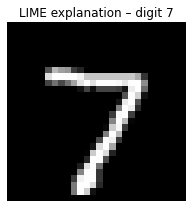

  0%|          | 0/1000 [00:00<?, ?it/s]

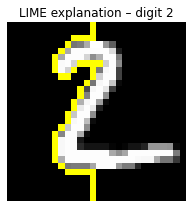

  0%|          | 0/1000 [00:00<?, ?it/s]

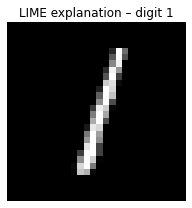

  0%|          | 0/1000 [00:00<?, ?it/s]

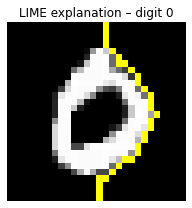

  0%|          | 0/1000 [00:00<?, ?it/s]

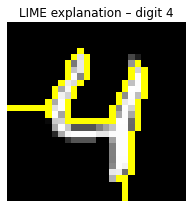

  0%|          | 0/1000 [00:00<?, ?it/s]

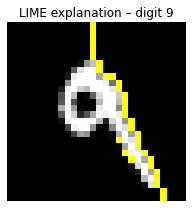

  0%|          | 0/1000 [00:00<?, ?it/s]

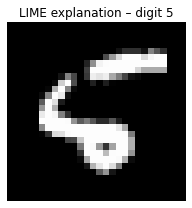

  0%|          | 0/1000 [00:00<?, ?it/s]

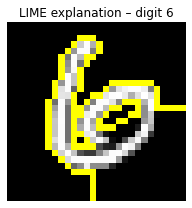

  0%|          | 0/1000 [00:00<?, ?it/s]

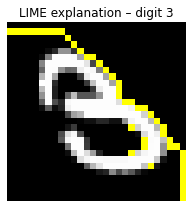

  0%|          | 0/1000 [00:00<?, ?it/s]

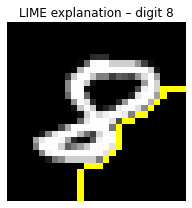


Saved figures ➜ /Users/samihamer/Desktop/Advanced Applied AI Summer 2025/Module 2/lime_figs


In [21]:
OUT_DIR = Path("lime_figs"); OUT_DIR.mkdir(exist_ok=True)
for digit, img_np in examples.items():
    exp = explainer.explain_instance(img_np,
                                     classifier_fn=batch_predict,
                                     top_labels=1,
                                     hide_color=0,
                                     num_samples=1000)
    # Explanation mask for predicted class (=digit)
    temp, mask = exp.get_image_and_mask(digit,
                                        positive_only=True,
                                        num_features=10,
                                        hide_rest=False)
    
    fig, ax = plt.subplots(figsize=(3,3))
    ax.imshow(mark_boundaries(temp.astype(np.uint8), mask))
    ax.set_title(f"LIME explanation – digit {digit}")
    ax.axis('off')
    fig.tight_layout()
    fig.savefig(OUT_DIR/f"digit_{digit}.png", dpi=150)
    plt.show()
print(f"\nSaved figures ➜ {OUT_DIR.resolve()}")